In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from roidetection import get_field_rois, get_score_rois, draw_rois, pairwise_dist
from scraper import crop_im

In [2]:
def alpha_blend(bg: np.ndarray, top: np.ndarray):
    '''
    https://en.wikipedia.org/wiki/Alpha_compositing#Alpha_blending
    '''
    # # Fix alpha=0 in top layer.
    # top[:, :, :3][top[:, :, 3] == 0] = 0
    
    bg = bg.astype(np.float32) / 255.0
    top = top.astype(np.float32) / 255.0
    a = top[:, :, 3]
    a = a[:, :, np.newaxis] * np.array([1, 1, 1])
    top_rgb = top[:, :, :3]
    return np.array((top_rgb * a + bg[:, :, :3] * (1 - a)) * 255, dtype=np.uint8)

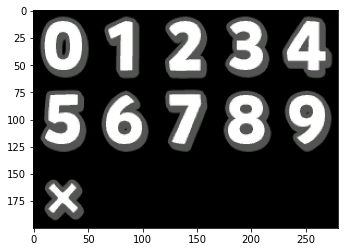

In [3]:
im = Image.open('test-images/num_font_d4444.png')
im = np.array(im)

white = np.zeros((im.shape[0], im.shape[1], 3), dtype=np.uint8)
im = alpha_blend(white, im)
im[150:195, 4:54] = im[455:500, 60:110]
im = im[:200, :280]
plt.imshow(im)
plt.show()

In [4]:
im_gray = np.dot(im[...,:3], [0.2989, 0.5870, 0.1140]).astype(np.uint8)

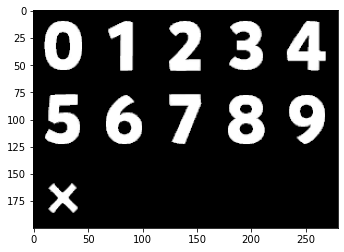

In [5]:
im_thresh = np.copy(im_gray)
im_thresh[im_gray < 100] = 0
plt.imshow(im_thresh, cmap='gray')
plt.show()

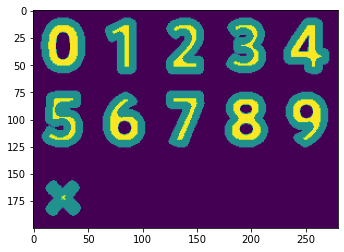

In [6]:
contours, hierarchy = cv2.findContours(im_thresh, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
# Only keep top hierarchy
hierarchy = hierarchy.reshape(-1, 4)
top_inds = np.argwhere(hierarchy[:, 3] == -1).reshape(-1)
contours = [contours[i] for i in top_inds]
hierarchy = hierarchy[top_inds]

contour_im = np.copy(im_thresh)
cv2.drawContours(contour_im, contours, -1, 128, 5)
plt.imshow(contour_im)

In [7]:
# Gotta sort the contours somehow...
rects = [cv2.boundingRect(contour) for contour in contours]
rects = np.array(rects)
print(rects) # x, y, w, h

[[ 14 159  27  27]
 [235  78  33  45]
 [179  78  34  45]
 [ 67  78  33  45]
 [125  77  30  46]
 [ 11  77  32  46]
 [233  10  36  46]
 [180  10  31  45]
 [125  10  29  46]
 [ 69  10  23  46]
 [ 10  10  35  45]]


In [8]:
zero_to_four_rect = rects[np.argwhere(rects[:, 1] == 10).reshape(-1)]
zero_to_four_contours = [contours[i] for i in np.argwhere(rects[:, 1] == 10).reshape(-1)]
five_to_nine_rect = rects[np.argwhere((rects[:, 1] == 77) + (rects[:, 1] == 78)).reshape(-1)]
five_to_nine_contours = [contours[i] for i in np.argwhere((rects[:, 1] == 77) + (rects[:, 1] == 78)).reshape(-1)]
the_x_rect = rects[np.argwhere((rects[:, 1] == 159)).reshape(-1)]
the_x_contours = [contours[i] for i in np.argwhere((rects[:, 1] == 159)).reshape(-1)]

print(zero_to_four_rect)
print(five_to_nine_rect)
print(the_x_rect)

# Then, sort them from left to right
zero_to_four = [zero_to_four_contours[i] for i in np.argsort(zero_to_four_rect[:, 0])]
five_to_nine = [five_to_nine_contours[i] for i in np.argsort(five_to_nine_rect[:, 0])]
the_x = [the_x_contours[i] for i in np.argsort(the_x_rect[:, 0])]

[[233  10  36  46]
 [180  10  31  45]
 [125  10  29  46]
 [ 69  10  23  46]
 [ 10  10  35  45]]
[[235  78  33  45]
 [179  78  34  45]
 [ 67  78  33  45]
 [125  77  30  46]
 [ 11  77  32  46]]
[[ 14 159  27  27]]


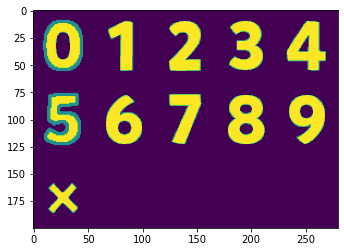

In [9]:
sorted_contours = [*zero_to_four, *five_to_nine, *the_x]
contour_im = np.copy(im_thresh)
cv2.drawContours(contour_im, sorted_contours, 0, 128, 2)
cv2.drawContours(contour_im, sorted_contours, 5, 128, 2)
plt.imshow(contour_im)

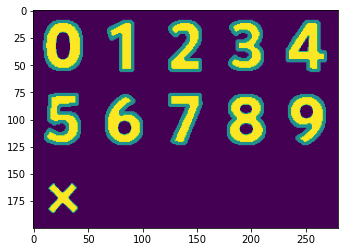

In [10]:
contour_im = np.copy(im_thresh)
cv2.drawContours(contour_im, sorted_contours[:-1], -1, 128, 2)
plt.imshow(contour_im)

In [11]:
number_hus = [cv2.HuMoments(cv2.moments(contour)).reshape(-1) for contour in sorted_contours[:-1]]
number_hus = np.array(number_hus)

x_hu = cv2.HuMoments(cv2.moments(sorted_contours[-1]))

## Detect X - Hu Moments?

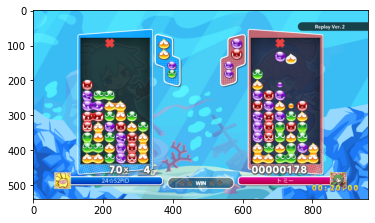

In [12]:
score_sample = Image.open('test-images/score-x.png').convert('RGB')
score_sample = np.array(score_sample)[..., :3]
plt.imshow(score_sample)
plt.show()

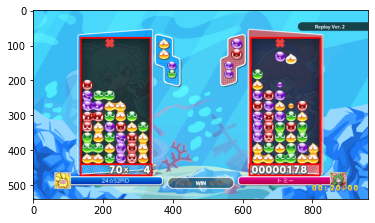

In [13]:
# get_field_rois, get_score_rois, draw_rois
found_field, field_rois = get_field_rois(score_sample)
score_rois = get_score_rois(field_rois)

roi_im = draw_rois(score_sample, [field_rois, score_rois])
plt.imshow(roi_im)
plt.show()

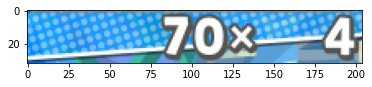

In [48]:
p1_score = crop_im(score_sample, score_rois[0])
plt.imshow(p1_score)
plt.show()

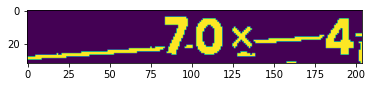

In [49]:
score_gray = np.dot(p1_score[...,:3], [0.2989, 0.5870, 0.1140]).astype(np.uint8)
score_thresh = np.zeros((p1_score.shape[0], p1_score.shape[1]), dtype=np.uint8)
score_thresh[score_gray > 200] = 255
plt.imshow(score_thresh)

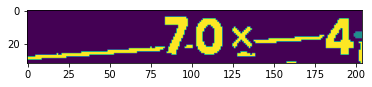

In [50]:
contours, hierarchy = cv2.findContours(score_thresh, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
# Only keep top hierarchy
hierarchy = hierarchy.reshape(-1, 4)
top_inds = np.argwhere(hierarchy[:, 3] == -1).reshape(-1)
contours = [contours[i] for i in top_inds]
hierarchy = hierarchy[top_inds]

contour_im = np.copy(score_thresh)
cv2.drawContours(contour_im, contours, 6, 128, 2)
plt.imshow(contour_im)

In [51]:
# Get Hu Moments
hu_moments = [cv2.HuMoments(cv2.moments(contour)).reshape(-1) for contour in contours]
hu_moments = np.array(hu_moments)

# Get pairwise distances
dists = np.linalg.norm(hu_moments - x_hu.reshape(1, -1), axis=1).reshape(-1, 1)
np.argmin(dists)

6

In [52]:
# Match Shapes...?
dists = [cv2.matchShapes(the_x_contours[0], contour, cv2.CONTOURS_MATCH_I1, 0) for contour in contours]
np.argmin(dists)

6

## Template Matching...

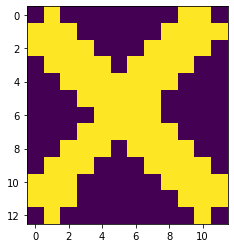

In [53]:
crop_x = score_thresh[10:23, 125:137]
plt.imshow(crop_x)

In [56]:
res = cv2.matchTemplate(score_thresh, crop_x, cv2.TM_CCOEFF_NORMED)
print(crop_x.shape)
print(res.shape)
print(score_thresh.shape)

(13, 12)
(20, 193)
(32, 204)


In [57]:
loc = np.where(res >= 0.8)
print(loc)

(array([10], dtype=int64), array([125], dtype=int64))


[(125, 10)]


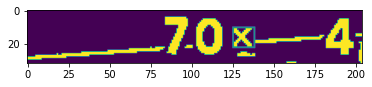

In [61]:
score_copy = np.copy(score_thresh)
w, h = crop_x.shape[:2]
print(list(zip(*loc[::-1])))
for pt in zip(*loc[::-1]):
    cv2.rectangle(score_copy, pt, (pt[0] + w, pt[1] + h), 128, 1)
plt.imshow(score_copy)

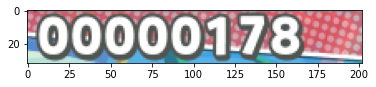

In [62]:
p2_score = crop_im(score_sample, score_rois[1])
plt.imshow(p2_score)
plt.show()

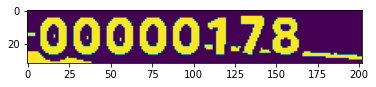

In [63]:
score_gray = np.dot(p2_score[...,:3], [0.2989, 0.5870, 0.1140]).astype(np.uint8)
score_thresh = np.zeros((p2_score.shape[0], p2_score.shape[1]), dtype=np.uint8)
score_thresh[score_gray > 200] = 255
plt.imshow(score_thresh)

(32, 202)
(13, 12)
(array([], dtype=int64), array([], dtype=int64))
0


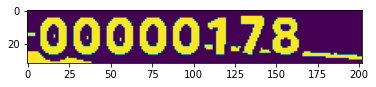

In [70]:
res = cv2.matchTemplate(score_thresh, crop_x, cv2.TM_CCOEFF_NORMED)
print(score_thresh.shape)
print(crop_x.shape)
loc = np.where(res >= 0.8)
print(loc)
score_copy = np.copy(score_thresh)
w, h = crop_x.shape[:2]
print(len(loc[0]))
for pt in zip(*loc[::-1]):
    cv2.rectangle(score_copy, pt, (pt[0] + w, pt[1] + h), 128, 1)
plt.imshow(score_copy)

## Player 2 Score

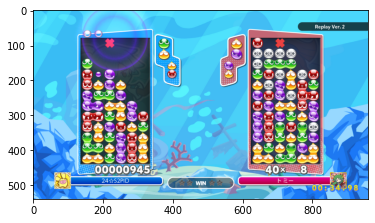

In [26]:
p2_sample = Image.open('test-images/score-x_p2.png').convert('RGB')
p2_sample = np.array(p2_sample)
plt.imshow(p2_sample)
plt.show()

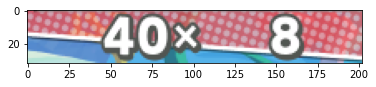

In [39]:
p2_score = crop_im(p2_sample, score_rois[1])
plt.imshow(p2_score)
plt.show()

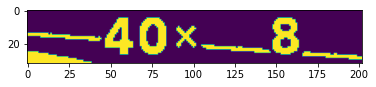

In [40]:
score_gray = np.dot(p2_score[...,:3], [0.2989, 0.5870, 0.1140]).astype(np.uint8)
score_thresh = np.zeros((p2_score.shape[0], p2_score.shape[1]), dtype=np.uint8)
score_thresh[score_gray > 200] = 255
plt.imshow(score_thresh)

(array([10], dtype=int64), array([90], dtype=int64))


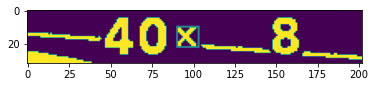

In [41]:
res = cv2.matchTemplate(score_thresh, crop_x, cv2.TM_CCOEFF_NORMED)
loc = np.where(res >= 0.8)
print(loc)
score_copy = np.copy(score_thresh)
w, h = crop_x.shape[:2]
for pt in zip(*loc[::-1]):
    cv2.rectangle(score_copy, pt, (pt[0] + w, pt[1] + h), 128, 1)
plt.imshow(score_copy)

In [32]:
print(crop_x)

[[  0 255   0   0   0   0   0   0   0 255 255   0]
 [255 255 255   0   0   0   0   0 255 255 255 255]
 [255 255 255 255   0   0   0 255 255 255 255   0]
 [  0 255 255 255 255   0 255 255 255 255   0   0]
 [  0   0 255 255 255 255 255 255 255   0   0   0]
 [  0   0   0 255 255 255 255 255   0   0   0   0]
 [  0   0   0   0 255 255 255 255   0   0   0   0]
 [  0   0   0 255 255 255 255 255 255   0   0   0]
 [  0   0 255 255 255   0 255 255 255 255   0   0]
 [  0 255 255 255   0   0   0 255 255 255 255   0]
 [255 255 255   0   0   0   0   0 255 255 255 255]
 [255 255 255   0   0   0   0   0   0 255 255 255]
 [  0 255   0   0   0   0   0   0   0   0 255   0]]


In [37]:
crop_x2 = Image.open('score-x-template.png').convert('L')

In [38]:
np.array(crop_x2)

array([[  0, 255,   0,   0,   0,   0,   0,   0,   0, 255, 255,   0],
       [255, 255, 255,   0,   0,   0,   0,   0, 255, 255, 255, 255],
       [255, 255, 255, 255,   0,   0,   0, 255, 255, 255, 255,   0],
       [  0, 255, 255, 255, 255,   0, 255, 255, 255, 255,   0,   0],
       [  0,   0, 255, 255, 255, 255, 255, 255, 255,   0,   0,   0],
       [  0,   0,   0, 255, 255, 255, 255, 255,   0,   0,   0,   0],
       [  0,   0,   0,   0, 255, 255, 255, 255,   0,   0,   0,   0],
       [  0,   0,   0, 255, 255, 255, 255, 255, 255,   0,   0,   0],
       [  0,   0, 255, 255, 255,   0, 255, 255, 255, 255,   0,   0],
       [  0, 255, 255, 255,   0,   0,   0, 255, 255, 255, 255,   0],
       [255, 255, 255,   0,   0,   0,   0,   0, 255, 255, 255, 255],
       [255, 255, 255,   0,   0,   0,   0,   0,   0, 255, 255, 255],
       [  0, 255,   0,   0,   0,   0,   0,   0,   0,   0, 255,   0]],
      dtype=uint8)